In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
import transformers
from transformers import DPTImageProcessor, DPTForDepthEstimation
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from tabulate import tabulate
import cv2
import pandas as pd
from collections import defaultdict

print(torch.__version__)
print(transformers.__version__)
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path

def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"Function '{func.__name__}' took {end_time - start_time:.4f} seconds")
        return result
    return wrapper

/Users/gorjanradevski/miniconda3/envs/iristick/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.4.0
4.51.3


In [2]:
# Select best available device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"The device is: {device}")

The device is: mps


In [3]:
def compute_depth_metrics(gt, pred, mask=None):
    # Ensure shape match
    if pred.ndim > 2:
        pred = pred.squeeze()  # [1, 1, H, W] -> [H, W]
    if gt.ndim > 2:
        gt = gt.squeeze()
    if mask is None:
        mask = gt > 0

    gt, pred = gt[mask], pred[mask]

    abs_rel = torch.mean(torch.abs(gt - pred) / gt)
    rmse = torch.sqrt(torch.mean((gt - pred) ** 2))
    rmse_log = torch.sqrt(torch.mean((torch.log(gt) - torch.log(pred)) ** 2))

    delta = torch.max(gt / pred, pred / gt)
    a1 = torch.mean((delta < 1.25).float())
    a2 = torch.mean((delta < 1.25 ** 2).float())
    a3 = torch.mean((delta < 1.25 ** 3).float())

    return {
        'AbsRel': abs_rel.item(),
        'RMSE': rmse.item(),
        'RMSE_log': rmse_log.item(),
        'a1': a1.item(),
        'a2': a2.item(),
        'a3': a3.item(),
    }


# prepare image for the model
class DepthModel:
    def __init__(self, model_name: str, device):
        self.image_processor = AutoImageProcessor.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForDepthEstimation.from_pretrained(model_name)
        self.model = self.model.to(device)
        self.device = device

    @timeit
    def __call__(self, image: Image):
        inputs = self.image_processor(images=image, return_tensors="pt")
        inputs = {k:v.to(self.device) for k,v in inputs.items()}
    
        with torch.no_grad():
            outputs = self.model(**inputs)
            predicted_depth = outputs.predicted_depth
    
        # interpolate to original size
        prediction = torch.nn.functional.interpolate(
            predicted_depth.cpu().unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        return prediction.cpu()
        # print(prediction, prediction.shape)


def visualize_depth(depth):
    output = depth.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    plt.imshow(formatted, cmap="viridis")


def visualize_all_models(image_id, results_dict, root_path, figsize=(18, 3)):
    n_models = len(results_dict[image_id]["preds"]) + 2  # +1 for GT, +1 for RGB
    fig, axes = plt.subplots(1, n_models, figsize=figsize, dpi=150)

    # Load and display original RGB image
    rgb_path = root_path / f"{image_id}_color.png"
    rgb_image = Image.open(rgb_path)
    axes[0].imshow(rgb_image)
    axes[0].set_title("RGB")
    axes[0].axis("off")

    # Show GT
    gt_depth = results_dict[image_id]["gt"].squeeze().cpu().numpy()
    gt_img = (gt_depth * 255 / np.max(gt_depth)).astype("uint8")
    axes[1].imshow(gt_img, cmap="viridis")
    axes[1].set_title("Ground Truth")
    axes[1].axis("off")

    # Show predictions
    for i, (model_name, pred_tensor) in enumerate(results_dict[image_id]["preds"].items(), start=2):
        pred_depth = pred_tensor.squeeze().cpu().numpy()
        pred_img = (pred_depth * 255 / np.max(pred_depth)).astype("uint8")
        axes[i].imshow(pred_img, cmap="viridis")
        axes[i].set_title(model_name)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [5]:
image_ids = ["409238553452200", "409243305337100", "409547560576900", "409570843067100", "409573045097900", "409592125011600"]
model_sizes = [("Large", "Indoor"), ("Base", "Indoor"), ("Small", "Indoor"), ("Small", "Outdoor")]
all_results = {}
depth_maps = defaultdict(lambda: {"gt": None, "preds": {}})

root_path = Path("data/saved_images/")

In [7]:
for model_size, setting in model_sizes:
    model_name = f"depth-anything/Depth-Anything-V2-Metric-{setting}-{model_size}-hf"
    depth_model = DepthModel(model_name=model_name, device=device)
    model_results = []
    print(f"============= Evaluating: {model_size} | {setting} =========== ")
    for image_id in image_ids:
        image_path = root_path / f"{image_id}_color.png"
        pred_depth = depth_model(image=Image.open(image_path))
        gt_depth = torch.load(root_path / f"{image_id}_depthpro.pt")
        metrics = compute_depth_metrics(gt=gt_depth.cpu(), pred=pred_depth.cpu())
        model_results.append(metrics)

        # Store predictions
        depth_maps[image_id]["gt"] = gt_depth
        depth_maps[image_id]["preds"][f"{model_size}-{setting}"] = pred_depth
        
    all_results[f"{model_size}-{setting}"] = model_results

# Convert list of dicts -> DataFrame per model, then average
summary_rows = []

for model_size, results in all_results.items():
    df = pd.DataFrame(results)
    mean_metrics = df.mean()
    summary_row = {"Model": model_size}
    summary_row.update(mean_metrics.to_dict())
    summary_rows.append(summary_row)

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index("Model")
markdown_table = tabulate(summary_df, headers='keys', tablefmt='github', floatfmt=".4f")
print(markdown_table)

`use_fast` is set to `True` but the image processor class does not have a fast version.  Falling back to the slow version.


============= Evaluating: Large | Indoor =========== 


/Users/gorjanradevski/miniconda3/envs/iristick/lib/python3.9/site-packages/torch/nn/functional.py:4095: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1720538194305/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(input, output_size, align_corners, scale_factors)


Function '__call__' took 1.2981 seconds


/var/folders/qh/w1ssgdwn6s30bxjgdyk4th8m0000gn/T/ipykernel_44173/2458317079.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gt_depth = torch.load(root_path / f"{image_id

Function '__call__' took 1.0176 seconds
Function '__call__' took 1.0114 seconds
Function '__call__' took 1.0101 seconds
Function '__call__' took 1.0119 seconds
Function '__call__' took 1.0088 seconds
============= Evaluating: Base | Indoor =========== 
Function '__call__' took 0.4396 seconds
Function '__call__' took 0.3485 seconds
Function '__call__' took 0.3478 seconds
Function '__call__' took 0.3478 seconds
Function '__call__' took 0.3488 seconds
Function '__call__' took 0.3495 seconds
============= Evaluating: Small | Indoor =========== 
Function '__call__' took 0.2355 seconds
Function '__call__' took 0.1561 seconds
Function '__call__' took 0.1587 seconds
Function '__call__' took 0.1537 seconds
Function '__call__' took 0.1528 seconds
Function '__call__' took 0.1505 seconds
============= Evaluating: Small | Outdoor =========== 
Function '__call__' took 0.1711 seconds
Function '__call__' took 0.1608 seconds
Function '__call__' took 0.1508 seconds
Function '__call__' took 0.1537 second

| Model   |   AbsRel |   RMSE |   RMSE_log |     a1 |     a2 |     a3 | InferenceTime (seconds) |
|---------|----------|--------|------------|--------|--------|--------|---------------|
| DepthPro      | - | - | - | - | - | - | 8.7888 |
| Large-Indoor   |   0.4425 | 0.3801 |     0.4187 | 0.6809 | 0.7738 | 0.8089 | 1.0409 |
| Base-Indoor    |   0.5581 | 0.5540 |     0.4776 | 0.4985 | 0.7584 | 0.7907 | 0.3980 |
| Small-Indoor   |   0.6536 | 0.7839 |     0.5212 | 0.3323 | 0.6000 | 0.8185 | 0.1638 |
| Small-Outdoor |   4.9403 | 7.0643 |     1.6572 | 0.0081 | 0.0506 | 0.1762 | - |

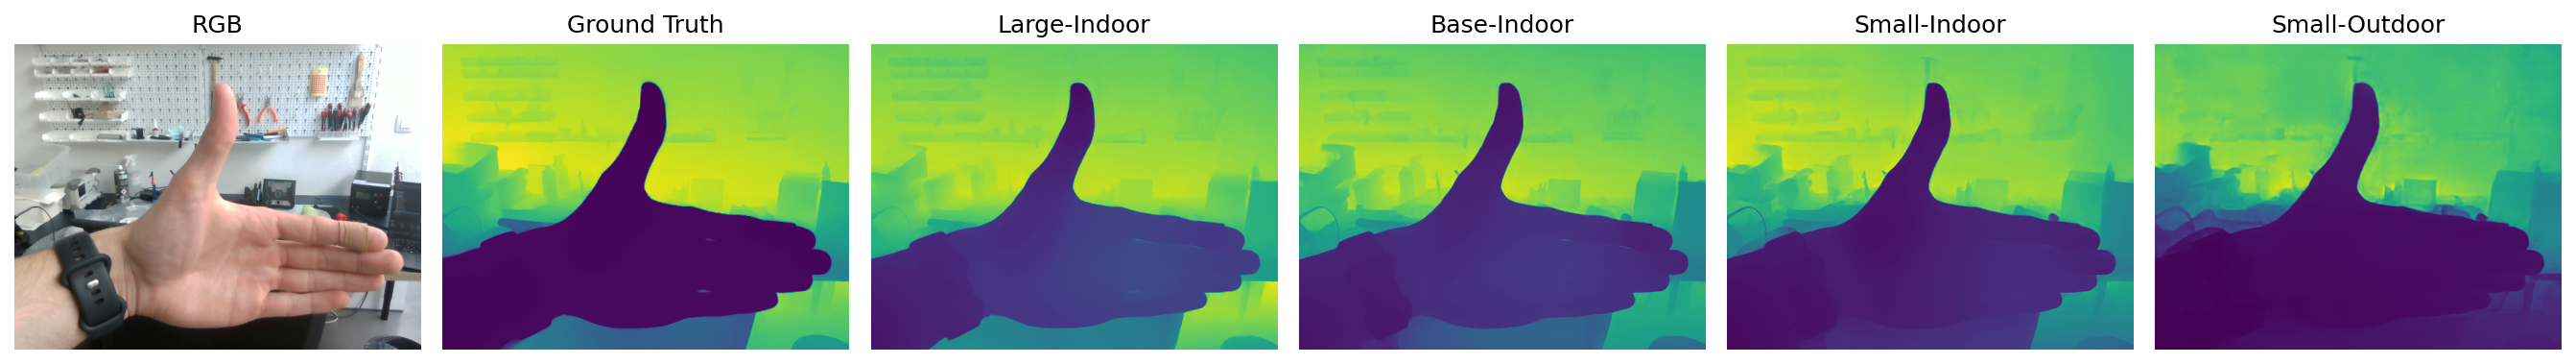

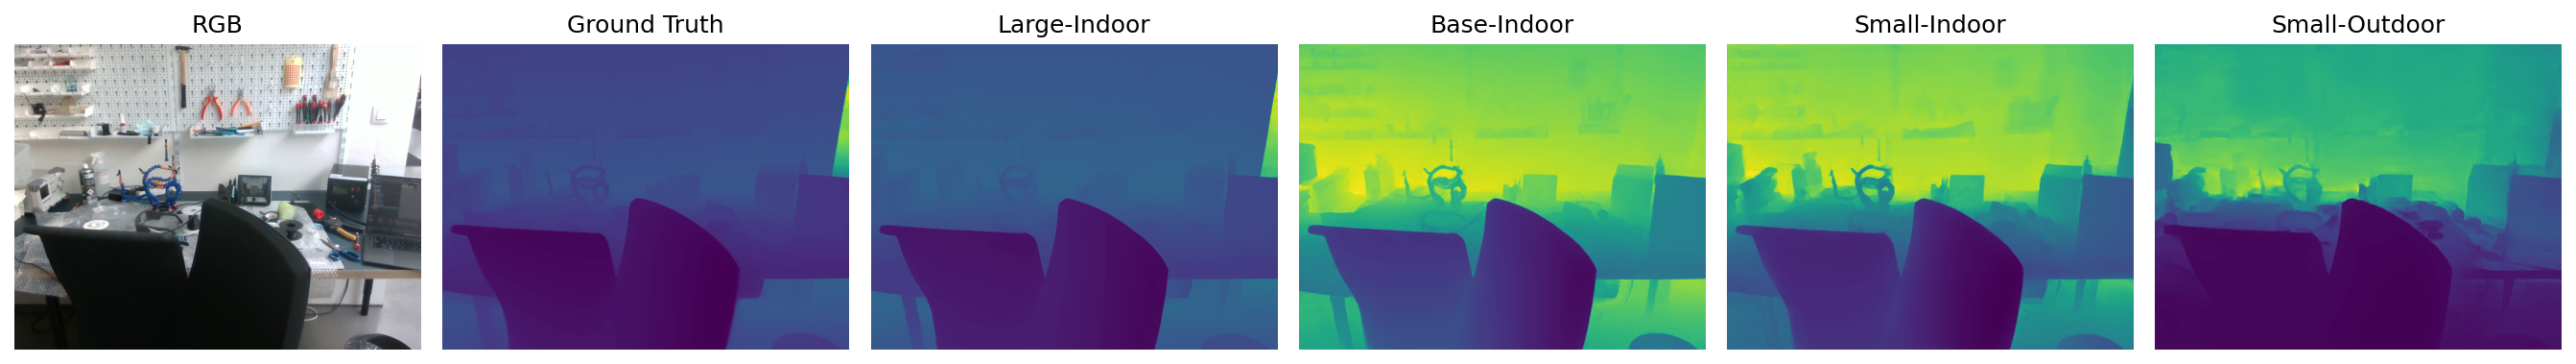

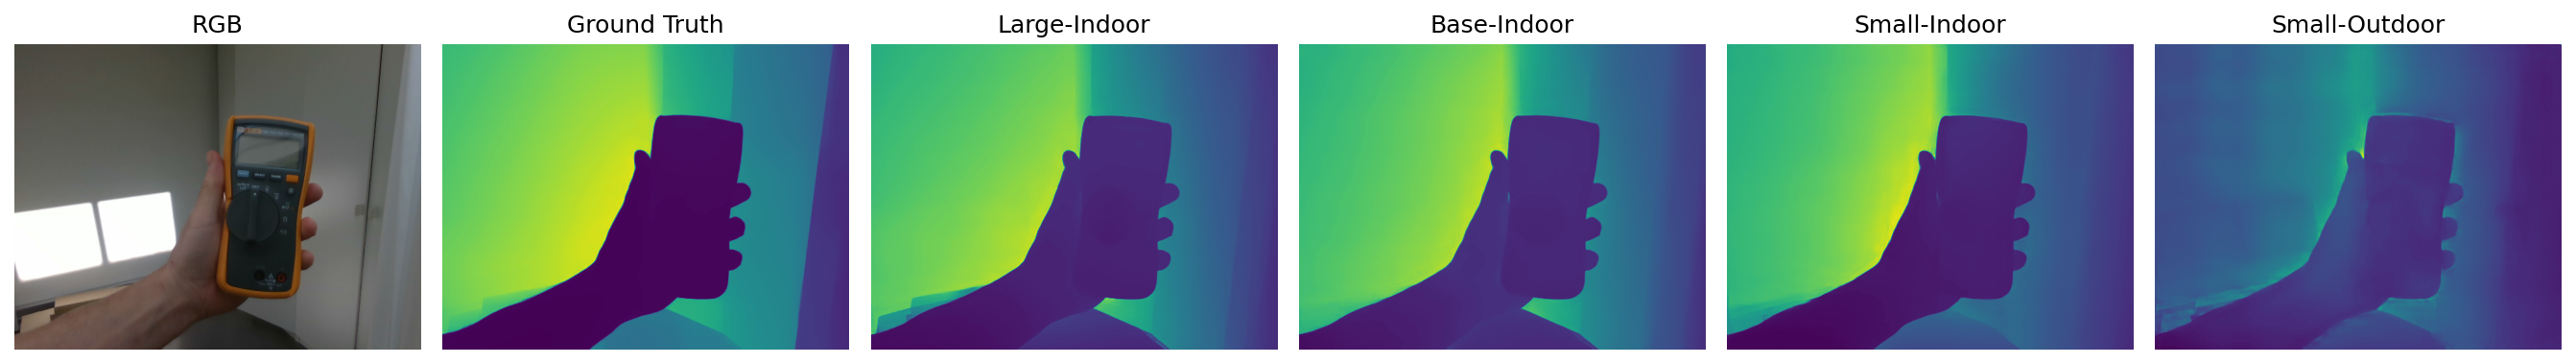

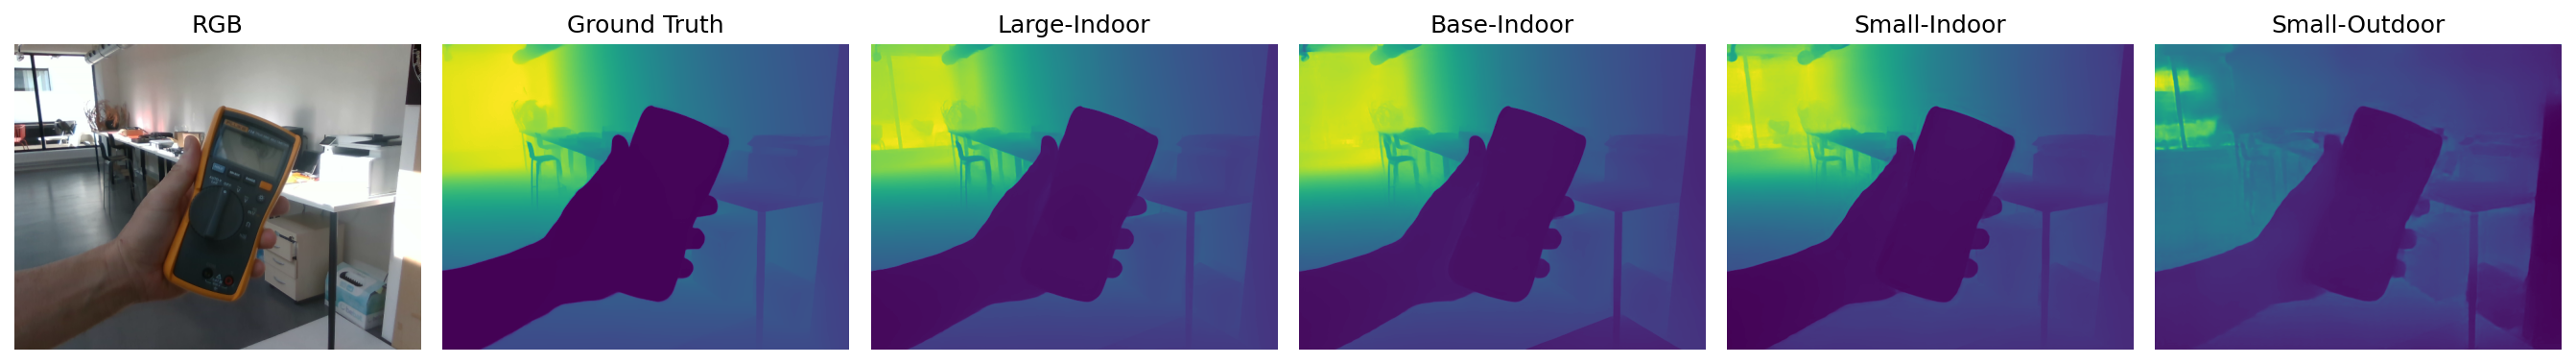

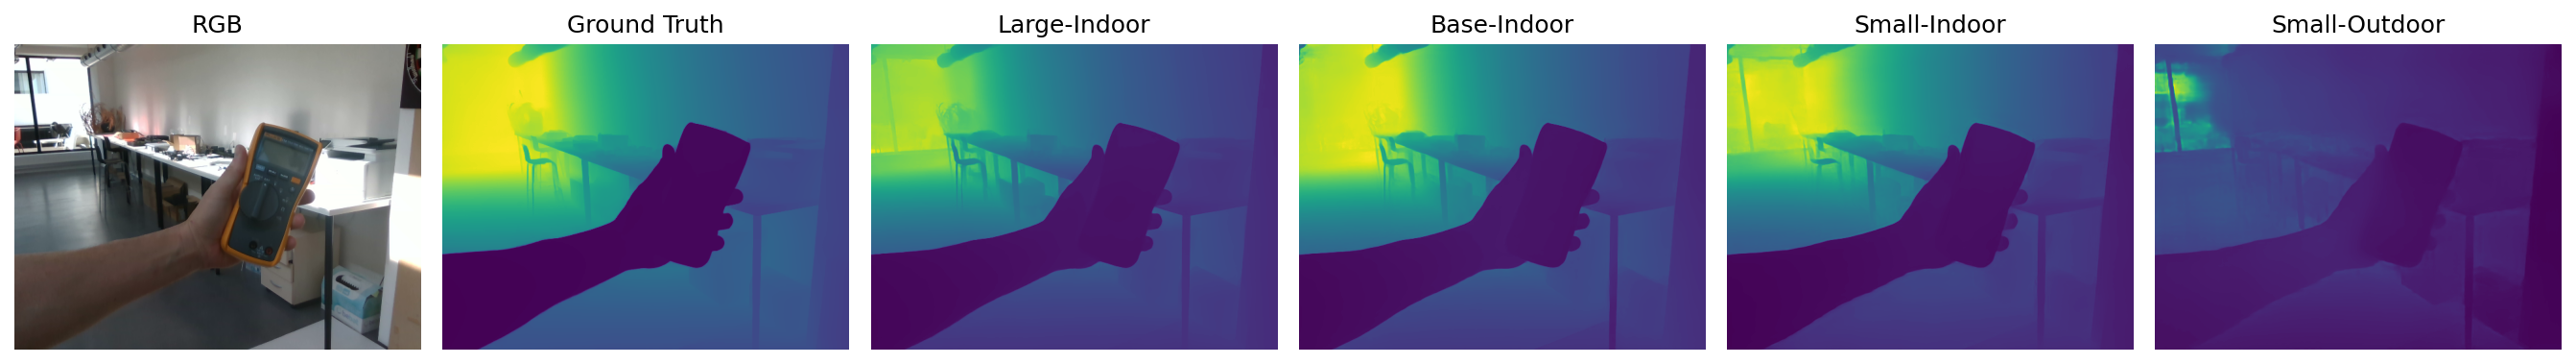

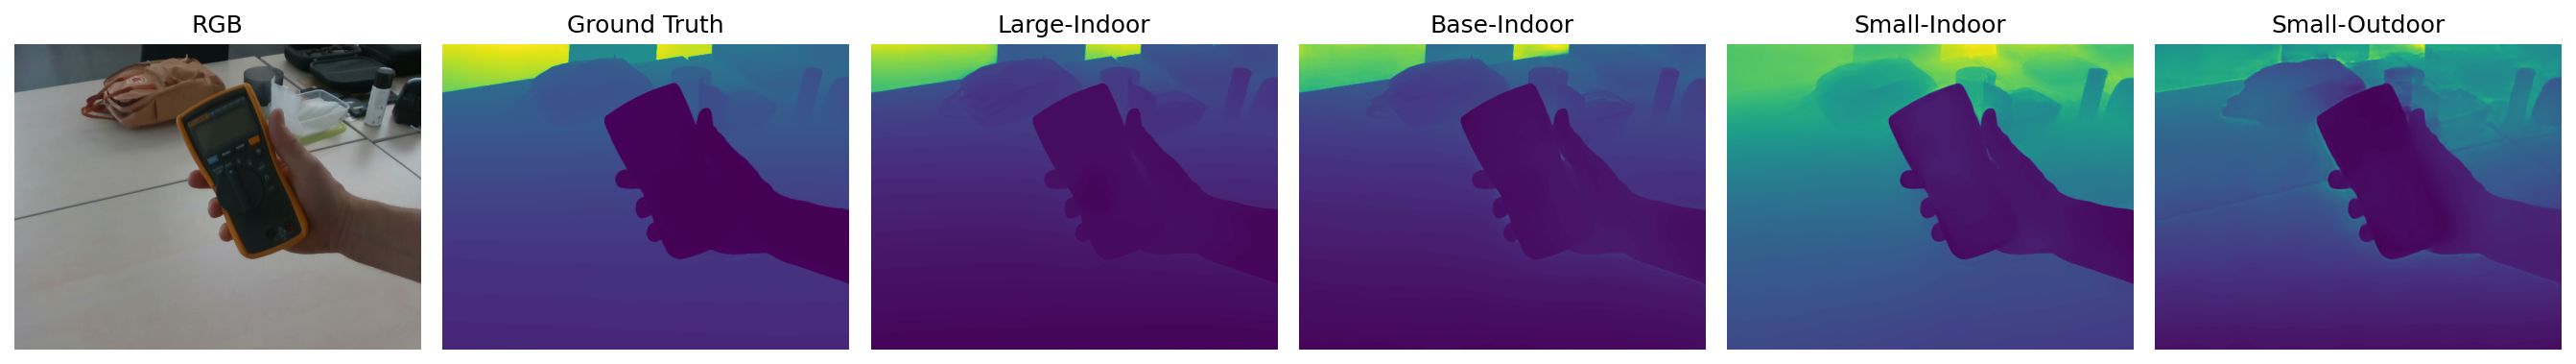

In [8]:
for image_id in image_ids:
    visualize_all_models(image_id, depth_maps, root_path=root_path)

(640, 480)


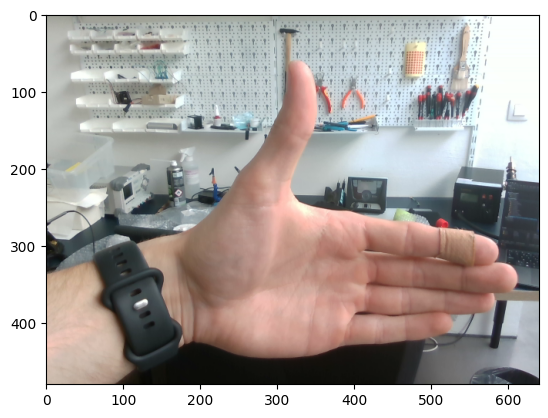

In [4]:
image_path = "data/saved_images/409238553452200_color.png"
image = Image.open(image_path)
print(image.size)
plt.imshow(image)

Function '__call__' took 1.3309 seconds


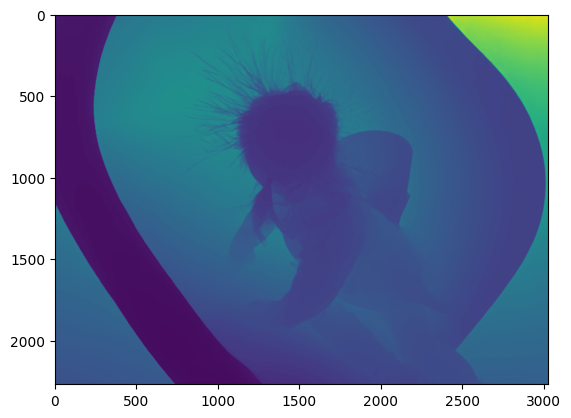

In [11]:
image_path = "data/example.jpg"
image = Image.open(image_path)

model_name = "depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf"
depth_model = DepthModel(model_name=model_name, device=device)

depth = depth_model(image=image)
visualize_depth(depth)

In [ ]:
model_name = "depth-anything/Depth-Anything-V2-Metric-Indoor-Large-hf"
depth_model = DepthModel(model_name=model_name, device=device)
depth = depth_model(image=image)
# visualize the prediction
plt.imshow(depth, cmap="viridis")

In [ ]:
tiny = "Intel/dpt-swinv2-tiny-256"
large = "Intel/dpt-swinv2-large-384"
hybrid = "Intel/dpt-hybrid-midas"

image_processor = DPTImageProcessor.from_pretrained(large)
model = DPTForDepthEstimation.from_pretrained(large, low_cpu_mem_usage=False)

model = model.to(device)

In [ ]:
@timeit
def inference(image: Image, model: DPTForDepthEstimation):
    # Prepare
    inputs = image_processor(images=image, return_tensors="pt")
    inputs = {k:v.to(device) for k,v in inputs.items()}
    # Forward
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth
    # interpolate to original size
    prediction = torch.nn.functional.interpolate(
        predicted_depth.cpu().unsqueeze(1),
        size=image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )
    output = prediction.squeeze().cpu().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)
    return depth

image_path = "data/saved_images/409238553452200_color.png"
image = Image.open(image_path)
depth = inference(image=image, model=model)
# visualize the prediction

plt.imshow(depth, cmap="viridis")

In [ ]:
def normalize_tensor_depth(tensor_depth):
    array = tensor_depth.squeeze().cpu().numpy()
    norm = (array - np.min(array)) / (np.max(array) - np.min(array))
    return norm

def normalize_16bit_depth(path):
    depth = cv2.imread(path, cv2.IMREAD_UNCHANGED).astype(np.float32)
    depth_m = depth / 1000.0
    depth_m[depth_m == 0] = np.nan
    norm = (depth_m - np.nanmin(depth_m)) / (np.nanmax(depth_m) - np.nanmin(depth_m))
    return norm

image_ids = [
    "409238553452200", "409243305337100", "409547560576900",
    "409570843067100", "409573045097900", "409592125011600"
]

root_path = "data/saved_images/"

for image_id in image_ids:
    color_path = f"{root_path}{image_id}_color.png"
    depthpro_path = f"{root_path}{image_id}_depthpro.pt"
    realsense_path = f"{root_path}{image_id}_depth_scaled.png"

    # Load images
    color_img = Image.open(color_path)
    depthpro = normalize_tensor_depth(torch.load(depthpro_path))
    # realsense = normalize_16bit_depth(realsense_path)
    realsense = Image.open(realsense_path)

    # Plot side-by-side
    plt.figure(figsize=(15, 5))
    # plt.suptitle(f"Image ID: {image_id}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(color_img)
    plt.title("Original RGB")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(depthpro, cmap="viridis")
    plt.title("DepthPro")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(realsense, cmap="viridis")
    plt.title("RealSense Depth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()
